In [1]:
import pandas as pd 
import numpy as np
import degree_codes as dc
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark-palette')
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.combine import SMOTETomek
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from dmba import classificationSummary, gainsChart
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import pprint

In [2]:
df=pd.read_csv('main_df.csv')
df.head(3)

,YEAR,MULTYEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STATEFIP,STRATA,GQ,...,INCWAGE,State,under_represented,domestic_born,EDU_verbose,is_STEM_degree,Degree,Degree_D,JobRole,stemType
0,2020,2016,202003,6676264,2016000978820,5.15,2020066762643,55,10055,1,...,51776,Wisconsin,0,1,High School,0,NaN,NaN,couriers and messengers,-1
1,2020,2016,202003,4027595,2016000661290,17.51,2020040275953,36,60036,1,...,21573,New York,0,1,High School,0,NaN,NaN,miscellaneous production workers including equ...,-1
2,2020,2017,202003,5156019,2017000181278,6.18,2020051560193,42,370142,1,...,0,Pennsylvania,0,0,Bachelor,0,Criminal Justice and Fire Protection,Criminal Justice and Fire Protection,elementary and middle school teachers,-1


In [3]:
#selecting the feautures for modeling
df_model=df[[
    'SEX'
    #,'RACE'
    ,'AGE'
    ,'domestic_born'
    ,'EDU_verbose'
    ,'is_STEM_degree'
    ,'under_represented'
    ,'stemType'
]]
del df

In [4]:
df_model['stemType'].value_counts()

-1                                                                                 189173
Research, Development, Design, and Practitioners                                     4052
Managerial                                                                            768
Research, Development, Design, and Practitioners; Technologists and Technicians       612
Technologists and Technicians                                                         355
Sales                                                                                  39
Name: stemType, dtype: int64

In order to run any sort of modeling on stemType, our target variable, we have to binarize it by employing a lambda function. At this point, stemType indicates whether an individual works in STEM, rather than which STEM field they're employed in :

In [5]:
def binarize_stem(x):
    if x == '-1':
        return 0
    return 1

#binarize STEM
df_model['stemType'] = df_model['stemType'].map(binarize_stem)

#switch SEX from 1,2 to 0,1
df_model['SEX'] = df_model['SEX']-1

df_model['stemType'].head(3)

0    0
1    0
2    0
Name: stemType, dtype: int64

Given that there's several different levels of education, we would benefit from using dummy variables in our modeling for them:

In [6]:
#a = pd.get_dummies(df_model['RACE'], prefix = "RACE")# get dummy variables for Race
b = pd.get_dummies(df_model['EDU_verbose'],prefix='EDU_verbose')#get dummy variables for Education

frames = [
    df_model
    #, a
    , b] # append them as a list
df_model = pd.concat(frames, axis = 1)
df_model=df_model.drop(columns = [
    'EDU_verbose'
    #, 'RACE'
]) 

Finally, to keep scale consistent, we would want to normalize the AGE variable to avoid giving it more weight:

In [7]:
denom = df_model['AGE'].max() - df_model['AGE'].min()
df_model['AGE'] = (df_model['AGE']-df_model['AGE'].min())/denom
df_model['AGE'].head(3)

0    0.448718
1    0.487179
2    0.217949
Name: AGE, dtype: float64

In [8]:
y=df_model['stemType']
y.value_counts()

0    189173
1      5826
Name: stemType, dtype: int64

### Check for class imbalance 

Percent of 0s: 97.01

Percent of 1s: 2.99


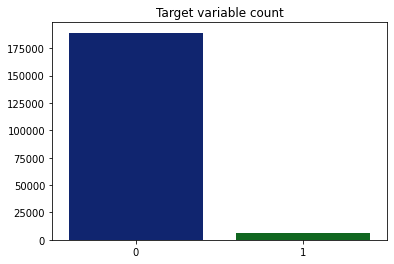

In [9]:
data = pd.DataFrame(df_model['stemType'])
percentage1 = round((data.stemType.sum() / data.shape[0]) * 100, 2) 
percentage0 = round(100 - percentage1, 2)
print('Percent of 0s:', percentage0)
print('\nPercent of 1s:', percentage1)
t=df_model['stemType'].value_counts().values
sns.barplot([0,1],t)
plt.title('Target variable count')
plt.show()

In [10]:
X = df_model.drop(columns=['stemType'])
y = df_model['stemType']
train_X, rem_X, train_y, rem_y = train_test_split(X, y, train_size=0.6, random_state=42, stratify = y)
valid_X, test_X, valid_y, test_y = train_test_split(rem_X, rem_y, train_size=0.5, random_state=42, stratify = rem_y) 

In [11]:
print('Training Set:\n', train_y.value_counts(), '\n', train_y.value_counts(normalize = True))
print('\nValidation Set:\n', valid_y.value_counts(), '\n', valid_y.value_counts(normalize = True))
print('\nTest Set:\n', test_y.value_counts(), '\n', test_y.value_counts(normalize = True))

Training Set:
 0    113503
1      3496
Name: stemType, dtype: int64 
 0    0.970119
1    0.029881
Name: stemType, dtype: float64

Validation Set:
 0    37835
1     1165
Name: stemType, dtype: int64 
 0    0.970128
1    0.029872
Name: stemType, dtype: float64

Test Set:
 0    37835
1     1165
Name: stemType, dtype: int64 
 0    0.970128
1    0.029872
Name: stemType, dtype: float64


In [12]:
try:
    train_X_res = pd.read_csv('SMOTE_df.csv')
    train_y_res = pd.read_csv('SMOTE_df_target.csv')
except:
    # Fixing the class imbalance with tomekLinks and SMOTE
    SMOTEtl = SMOTETomek(random_state = 42)

    # fit predictor and target variable for training set only
    train_X_res, train_y_res = SMOTEtl.fit_resample(train_X, train_y)

    print('Original dataset shape:\n', train_y.value_counts())
    print('Resampled dataset shape:\n', train_y_res.value_counts())

    train_X_res.to_csv('SMOTE_df.csv',index=None)
    train_y_res.to_csv('SMOTE_df_target.csv',index=None)

We can also save our SMOTE data to .csv to avoid having to re-run this data during development work for future replications, which is handled in the **except** statement above.

### Helper Function: Confusion Matrix

In [13]:
def confusionMatrices(model, title):
    print(title + ' - training results')
    classificationSummary(train_y_res, model.predict(train_X_res))
    print(title + ' - validation results')
    valid_pred = model.predict(valid_X)
    classificationSummary(valid_y, valid_pred)

### Helper Function: Evaluation Metrics

In [14]:
def evalMetrics(model,mod_predict,verbose=True):
    # precision tp / (tp + fp)
    precision = precision_score(test_y, mod_predict)
    # recall: tp / (tp + fn)
    recall = recall_score(test_y, mod_predict)
    
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(test_y, mod_predict)
    
    # ROC AUC
    lr_probs = model.predict_proba(test_X)
    lr_probs = lr_probs[:, 1]
    auc = roc_auc_score(test_y, lr_probs)
    
    if verbose:
        print('Precision: %f' % precision)
        print('Recall: %f' % recall)
        print('F1 score: %f' % f1)
        print('ROC AUC: %f' % auc)
        
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc":auc
    }

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(train_X_res, train_y_res)
confusionMatrices(gnb,'Naive Bayes')

#### Evaluation and Confusion Matrix:

In [ ]:
gnb_pred = gnb.predict(test_X)
evalMetrics(gnb,gnb_pred)
classificationSummary(test_y, gnb_pred)

### Logistic regression

In [ ]:
logit_reg = LogisticRegression(penalty="l1", C=1e42, solver='liblinear', random_state = 1)
logit_reg.fit(train_X_res, train_y_res)
confusionMatrices(logit_reg, 'Logistic regression')

#### Test Set

In [ ]:
logit_pred = logit_reg.predict(test_X)

#### Evaluation and Confusion Matrix

In [ ]:
evalMetrics(logit_reg,logit_pred)
classificationSummary(test_y, logit_pred)

### Random Forest - GridSearch

To optimize random forest performance, we want to cycle through the number of estimators, the maximum tree depth, the log-loss, the cost function, and more:

In [41]:
rf = RandomForestClassifier(random_state = 1,verbose = 2)

# Number of trees in random forest
n_estimators = [400,450,500,550,600]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint.pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [400, 450, 500, 550, 600]}


In [ ]:
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(
    estimator = rf
    , param_distributions = random_grid
    , n_iter = 100
    , cv = 3
    , verbose=2
    , random_state=1
    , n_jobs = -1
    , scoring = 'roc_auc'
)
# Fit the random search model
rf_random.fit(train_X_res, train_y_res)

We can see which parameters perform the best for our random forest:

Continue by reviewing the array of ROC scores we got from our models:

In [ ]:
RandomForest_pred = rf_random.predict(test_X)

In [46]:
evalMetrics(rf_random,RandomForest_pred)
classificationSummary(test_y, RandomForest_pred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s


Precision: 0.107517
Recall: 0.696137
F1 score: 0.186266
ROC AUC: 0.726414
Confusion Matrix (Accuracy 0.8183)

       Prediction
Actual     0     1
     0 31103  6732
     1   354   811


[Parallel(n_jobs=1)]: Done 550 out of 550 | elapsed:    3.9s finished


We can also compare this with our original model:

In [45]:
#current best roc ~ 83.7%
RandomForest = RandomForestClassifier(
    n_estimators=500 #current best = 500
    , random_state=1
    , max_depth = 6
)
RandomForest.fit(train_X_res, train_y_res)
RandomForest_pred = RandomForest.predict(test_X)
evalMetrics(RandomForest,RandomForest_pred)
classificationSummary(test_y, RandomForest_pred)

Precision: 0.107517
Recall: 0.696137
F1 score: 0.186266
ROC AUC: 0.837011
Confusion Matrix (Accuracy 0.8183)

       Prediction
Actual     0     1
     0 31103  6732
     1   354   811


it appears that despite our eforts to conduct some sort of gridsearch for our random forest model, we're unable to beat the roc of 83.7% using conventional means, and will have to approach this more carefully by tuning each metric alone until we get better insights.

#### 1. Number of Estimators

In [65]:
estimators = [200,250,300,350,400,425,450]
roc_scores = []

for e in estimators:
    RandomForest = RandomForestClassifier(
        n_estimators= e #current best = 500
        , random_state=1
        , max_depth = 6
    )
    RandomForest.fit(train_X_res, train_y_res)
    RandomForest_pred = RandomForest.predict(test_X)
    
    #get roc_auc
    this_roc = evalMetrics(RandomForest,RandomForest_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 1b. Visualization

we can conclude that around 250 estimators is an optimal number for our random forest clasifier.

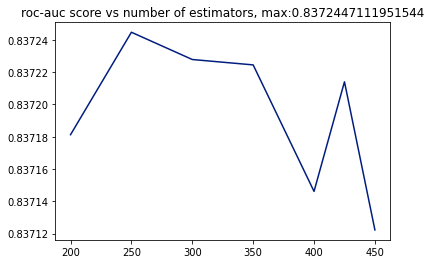

In [66]:
# plot
plt.plot(estimators,roc_scores)
plt.title(f'roc-auc score vs number of estimators, max:{max(roc_scores)}')
plt.show()

#### 2. max depth

In [60]:
depths = list(range(1,10))
roc_scores = []

for d in depths:
    RandomForest = RandomForestClassifier(
        n_estimators= 250 #current best = 500
        , random_state=1
        , max_depth = d
    )
    RandomForest.fit(train_X_res, train_y_res)
    RandomForest_pred = RandomForest.predict(test_X)
    
    #get roc_auc
    this_roc = evalMetrics(RandomForest,RandomForest_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 2b. Visualization

a max depth of 6 seems to be an optimal parameter at this stage.

In [62]:
roc_scores

[0.7990665477102691,
 0.8177539360823001,
 0.828600989954688,
 0.8327744197614331,
 0.8358456501037087,
 0.8372447111951544,
 0.837276961008127,
 0.8358849669703156,
 0.8314325416834221]

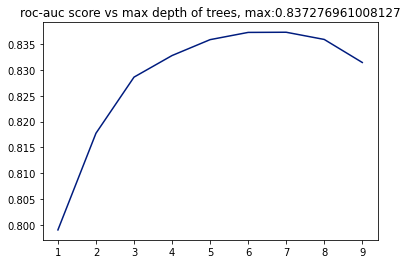

In [64]:
# plot
plt.plot(depths,roc_scores)
plt.title(f'roc-auc score vs max depth of trees, max:{max(roc_scores)}')
plt.show()

#### 3. Min sample split

In [70]:
min_samples_split = list(range(6,20,2))
roc_scores = []

for m in min_samples_split:
    RandomForest = RandomForestClassifier(
        n_estimators= 250 #current best = 500
        , random_state=1
        , max_depth = 6
        , min_samples_split = m
    )
    RandomForest.fit(train_X_res, train_y_res)
    RandomForest_pred = RandomForest.predict(test_X)
    
    #get roc_auc
    this_roc = evalMetrics(RandomForest,RandomForest_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 3b. Visualization
Optimal performance seems to be at a min-sample split of 12.

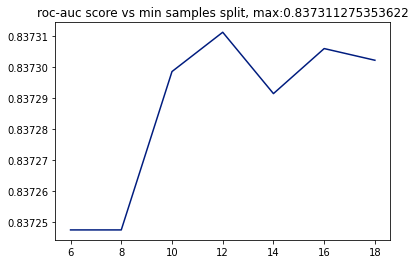

In [71]:
# plot
plt.plot(min_samples_split,roc_scores)
plt.title(f'roc-auc score vs min samples split, max:{max(roc_scores)}')
plt.show()

#### 4. Min samples per leaf

In [76]:
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,5,10,20,30,40,50,60,70,80,90,100,150,200,250,300]
roc_scores = []

for m in min_samples_leaf:
    RandomForest = RandomForestClassifier(
        n_estimators= 250 #current best = 500
        , random_state=1
        , max_depth = 6
        , min_samples_split = 12
        , min_samples_leaf = m
    )
    RandomForest.fit(train_X_res, train_y_res)
    RandomForest_pred = RandomForest.predict(test_X)
    
    #get roc_auc
    this_roc = evalMetrics(RandomForest,RandomForest_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 4b. Visualization
100 samples per leaf at a minimum is an optimal parameter.

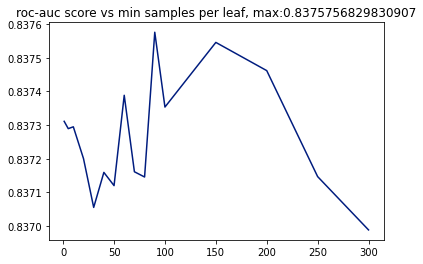

In [77]:
# plot
plt.plot(min_samples_leaf,roc_scores)
plt.title(f'roc-auc score vs min samples per leaf, max:{max(roc_scores)}')
plt.show()

### Neural Network

In [76]:
neuralNet = MLPClassifier(
    hidden_layer_sizes=(5)
    , activation='logistic'
    , solver='lbfgs'
    , max_iter=2000, 
    random_state=1
)
neuralNet.fit(train_X_res, train_y_res)
confusionMatrices(neuralNet, 'Neural Network')

Neural Network - training results
Confusion Matrix (Accuracy 0.7632)

       Prediction
Actual     0     1
     0 93503 19916
     1 33795 79624
Neural Network - validation results
Confusion Matrix (Accuracy 0.8175)

       Prediction
Actual     0     1
     0 31112  6723
     1   395   770


In [77]:
neuralNet_pred = neuralNet.predict(test_X)
classificationSummary(test_y, neuralNet_pred )

Confusion Matrix (Accuracy 0.8181)

       Prediction
Actual     0     1
     0 31084  6751
     1   345   820


In [78]:
# precision tp / (tp + fp)
precision = precision_score(test_y, neuralNet_pred )
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_y, neuralNet_pred )
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_y, neuralNet_pred )
print('F1 score: %f' % f1)
# ROC AUC
nn_probs = neuralNet.predict_proba(test_X)
nn_probs = nn_probs[:, 1]
auc = roc_auc_score(test_y, nn_probs)
print('ROC AUC: %f' % auc)

Precision: 0.108308
Recall: 0.703863
F1 score: 0.187729
ROC AUC: 0.840197


In [89]:
table = {'Models':["Logistic Regression", 
                   "Random Forest",
                   "Neural Network"],
         'Accuracy':[accuracy_score(test_y, logit_pred),
                     
                     accuracy_score(test_y, RandomForest_pred),
                     
                     accuracy_score(test_y, neuralNet_pred)],
         'Precision':[precision_score(test_y, logit_pred),
                   
                 
                      precision_score(test_y, RandomForest_pred),
                      
                      precision_score(test_y, neuralNet_pred) ],
         "Recall":[recall_score(test_y, logit_pred),
               
                   recall_score(test_y, RandomForest_pred),
          
                   recall_score(test_y,neuralNet_pred)],
         "F1_Score":[f1_score(test_y, logit_pred),
                    
                     f1_score(test_y, RandomForest_pred),
                   
                     f1_score(test_y,neuralNet_pred)],
         "ROC AUC":[roc_auc_score(test_y, lr_probs),
                   
                    roc_auc_score(test_y, rf_probs),
                  
                    roc_auc_score(test_y,  nn_probs)]
}
table_report = pd.DataFrame(table)
# print the data
table_report

,Models,Accuracy,Precision,Recall,F1_Score,ROC AUC
0,Logistic Regression,0.782205,0.093059,0.719313,0.164798,0.832059
1,Random Forest,0.818308,0.107517,0.696137,0.186266,0.837011
2,Neural Network,0.818051,0.108308,0.703863,0.187729,0.840197
